# 2. Train FasterRCNN on TT-100K using Detectron2

> @author: Wenzhen Zhu (wenzhen@wustl.edu)

> @date: 11/22/2021

> This notebook needs to have environment `conda_python2` for the TT-100K python helper functions are written in python2

## 1. Observe TT100K

In [1]:
import sys
sys.path.insert(0, "/home/ec2-user/SageMaker/cp-aug-traffic-sign/data/TT100K/code/python/")

In [125]:
import json, os
import pylab as pl
import random
import numpy as np
import cv2
import anno_func
%matplotlib inline

In [126]:
def ascii_encode_dict(data):
    ascii_encode = lambda x: x.encode('ascii')
    return dict(map(ascii_encode, pair) for pair in data.items())

In [39]:
datadir = "/home/ec2-user/SageMaker/cp-aug-traffic-sign/data/TT100K/data"

filedir = datadir + "/annotations.json"
ids = open(datadir + "/test/ids.txt").read().splitlines()
annos = json.loads(open(filedir).read())

Let's take a look about annotation json file, annos has two keys:

In [41]:
list(annos["imgs"])

[u'22748',
 u'35234',
 u'35232',
 u'35548',
 u'73392',
 u'73390',
 u'35542',
 u'35239',
 u'96076',
 u'1735',
 u'83893',
 u'55290',
 u'82103',
 u'19398',
 u'5982',
 u'5983',
 u'19395',
 u'24841',
 u'5986',
 u'19392',
 u'27391',
 u'73393',
 u'48898',
 u'82448',
 u'87963',
 u'22268',
 u'82441',
 u'61173',
 u'82195',
 u'61176',
 u'25061',
 u'43879',
 u'83895',
 u'43877',
 u'73464',
 u'32235',
 u'57485',
 u'73394',
 u'83899',
 u'27370',
 u'27371',
 u'82223',
 u'6790',
 u'46138',
 u'82998',
 u'82229',
 u'98318',
 u'98648',
 u'56126',
 u'98646',
 u'75942',
 u'97150',
 u'97157',
 u'97156',
 u'98640',
 u'24941',
 u'57294',
 u'15958',
 u'25287',
 u'25284',
 u'25282',
 u'25281',
 u'51843',
 u'272',
 u'15368',
 u'274',
 u'16708',
 u'278',
 u'80593',
 u'80591',
 u'88023',
 u'60094',
 u'97335',
 u'88712',
 u'88027',
 u'12018',
 u'88025',
 u'26127',
 u'12010',
 u'22660',
 u'64674',
 u'26396',
 u'64670',
 u'26390',
 u'26393',
 u'78753',
 u'17251',
 u'52462',
 u'29681',
 u'26399',
 u'17256',
 u'17257',

Use the first 2 annotations to test

In [93]:
ann = {k: annos["imgs"][k] for k in list(annos["imgs"])[:4]}

In [122]:
ann["22748"]["path"]

u'test/22748.jpg'

Build the look up table to map the category with id

In [107]:
types = sorted([decode(s) for s in annos["types"]])
category_map = {}
for i in range(len(types)):
    category_map[types[i]] = list(range(len(types)))[i] + 1

In [110]:
category_map = {'i1': 1,
 'i10': 2,
 'i11': 3,
 'i12': 4,
 'i13': 5,
 'i14': 6,
 'i15': 7,
 'i2': 8,
 'i3': 9,
 'i4': 10,
 'i5': 11,
 'i6': 12,
 'i7': 13,
 'i8': 14,
 'i9': 15,
 'il100': 16,
 'il110': 17,
 'il50': 18,
 'il60': 19,
 'il70': 20,
 'il80': 21,
 'il90': 22,
 'ilx': 23,
 'io': 24,
 'ip': 25,
 'p1': 26,
 'p10': 27,
 'p11': 28,
 'p12': 29,
 'p13': 30,
 'p14': 31,
 'p15': 32,
 'p16': 33,
 'p17': 34,
 'p18': 35,
 'p19': 36,
 'p2': 37,
 'p20': 38,
 'p21': 39,
 'p22': 40,
 'p23': 41,
 'p24': 42,
 'p25': 43,
 'p26': 44,
 'p27': 45,
 'p28': 46,
 'p29': 47,
 'p3': 48,
 'p4': 49,
 'p5': 50,
 'p6': 51,
 'p7': 52,
 'p8': 53,
 'p9': 54,
 'pa10': 55,
 'pa12': 56,
 'pa13': 57,
 'pa14': 58,
 'pa8': 59,
 'pax': 60,
 'pb': 61,
 'pc': 62,
 'pd': 63,
 'pe': 64,
 'pg': 65,
 'ph1.5': 66,
 'ph2': 67,
 'ph2.1': 68,
 'ph2.2': 69,
 'ph2.4': 70,
 'ph2.5': 71,
 'ph2.6': 72,
 'ph2.8': 73,
 'ph2.9': 74,
 'ph3': 75,
 'ph3.2': 76,
 'ph3.3': 77,
 'ph3.5': 78,
 'ph3.8': 79,
 'ph4': 80,
 'ph4.2': 81,
 'ph4.3': 82,
 'ph4.4': 83,
 'ph4.5': 84,
 'ph4.8': 85,
 'ph5': 86,
 'ph5.3': 87,
 'ph5.5': 88,
 'phx': 89,
 'pl0': 90,
 'pl10': 91,
 'pl100': 92,
 'pl110': 93,
 'pl120': 94,
 'pl15': 95,
 'pl20': 96,
 'pl25': 97,
 'pl3': 98,
 'pl30': 99,
 'pl35': 100,
 'pl4': 101,
 'pl40': 102,
 'pl5': 103,
 'pl50': 104,
 'pl60': 105,
 'pl65': 106,
 'pl70': 107,
 'pl80': 108,
 'pl90': 109,
 'plx': 110,
 'pm1.5': 111,
 'pm10': 112,
 'pm13': 113,
 'pm15': 114,
 'pm2': 115,
 'pm2.5': 116,
 'pm20': 117,
 'pm25': 118,
 'pm30': 119,
 'pm35': 120,
 'pm40': 121,
 'pm46': 122,
 'pm5': 123,
 'pm50': 124,
 'pm55': 125,
 'pm8': 126,
 'pmx': 127,
 'pn': 128,
 'pn40': 129,
 'pne': 130,
 'pnl': 131,
 'po': 132,
 'pr10': 133,
 'pr100': 134,
 'pr20': 135,
 'pr30': 136,
 'pr40': 137,
 'pr45': 138,
 'pr50': 139,
 'pr60': 140,
 'pr70': 141,
 'pr80': 142,
 'prx': 143,
 'ps': 144,
 'pw2': 145,
 'pw2.5': 146,
 'pw3': 147,
 'pw3.2': 148,
 'pw3.5': 149,
 'pw4': 150,
 'pw4.2': 151,
 'pw4.5': 152,
 'pwx': 153,
 'w1': 154,
 'w10': 155,
 'w11': 156,
 'w12': 157,
 'w13': 158,
 'w14': 159,
 'w15': 160,
 'w16': 161,
 'w17': 162,
 'w18': 163,
 'w19': 164,
 'w2': 165,
 'w20': 166,
 'w21': 167,
 'w22': 168,
 'w23': 169,
 'w24': 170,
 'w25': 171,
 'w26': 172,
 'w27': 173,
 'w28': 174,
 'w29': 175,
 'w3': 176,
 'w30': 177,
 'w31': 178,
 'w32': 179,
 'w33': 180,
 'w34': 181,
 'w35': 182,
 'w36': 183,
 'w37': 184,
 'w38': 185,
 'w39': 186,
 'w4': 187,
 'w40': 188,
 'w41': 189,
 'w42': 190,
 'w43': 191,
 'w44': 192,
 'w45': 193,
 'w46': 194,
 'w47': 195,
 'w48': 196,
 'w49': 197,
 'w5': 198,
 'w50': 199,
 'w51': 200,
 'w52': 201,
 'w53': 202,
 'w54': 203,
 'w55': 204,
 'w56': 205,
 'w57': 206,
 'w58': 207,
 'w59': 208,
 'w6': 209,
 'w60': 210,
 'w61': 211,
 'w62': 212,
 'w63': 213,
 'w64': 214,
 'w65': 215,
 'w66': 216,
 'w67': 217,
 'w7': 218,
 'w8': 219,
 'w9': 220,
 'wo': 221}

In [113]:
def create_image_info(image_id, file_name, file_path, image_size, datetime):
    image_info = {
        "id": image_id,
        "file_name": file_name,
        "file_path": file_path,
        "s3_url": s3_url,
        "width": image_size[0],
        "height": image_size[1],
    }
    return image_info

In [130]:
def load_img(annos, data_dir, img_id):
    img = annos[img_id]
    img_path = os.path.join(data_dir, img["path"])
    print(img_path)
    img_data = pl.imread(img_path)
    if img_data.max() > 2:
        img_data = img_data / 255.
    return img_data

In [140]:
annos

{u'imgs': {u'22748': {u'id': 22748,
   u'objects': [{u'bbox': {u'xmax': 1313.8614,
      u'xmin': 1280.2,
      u'ymax': 911.8811999999999,
      u'ymin': 877.228},
     u'category': u'pne',
     u'ellipse': [[1297.284912109375, 892.2813110351562],
      [29.203319549560547, 32.51068115234375],
      34.67168045043945],
     u'ellipse_org': [[1305.57, 878.996],
      [1286.93, 883.454],
      [1283.08, 899.261],
      [1295.14, 908.684],
      [1309.73, 901.186]]},
    {u'bbox': {u'xmax': 1432.6733000000002,
      u'xmin': 1405.94,
      u'ymax': 910.8910999999999,
      u'ymin': 877.228},
     u'category': u'i5',
     u'ellipse': [[1419.677490234375, 893.7010498046875],
      [28.62367820739746, 31.684654235839844],
      6.196252346038818],
     u'ellipse_org': [[1431.76, 883.017],
      [1412.96, 881.54],
      [1405.48, 895.419],
      [1415.43, 908.313],
      [1427.73, 908.313],
      [1433.34, 896.797]]},
    {u'bbox': {u'xmax': 1592.087,
      u'xmin': 1573.27,
      u'ymax': 9

In [141]:
imgData = load_img(annos['imgs'], "/home/ec2-user/SageMaker/cp-aug-traffic-sign/data/TT100K/data", "10063")

/home/ec2-user/SageMaker/cp-aug-traffic-sign/data/TT100K/data/test/10063.jpg


In [135]:
imgData.shape

(2048, 2048, 3)

In [117]:
ann

{u'22748': {u'id': 22748,
  u'objects': [{u'bbox': {u'xmax': 1313.8614,
     u'xmin': 1280.2,
     u'ymax': 911.8811999999999,
     u'ymin': 877.228},
    u'category': u'pne',
    u'ellipse': [[1297.284912109375, 892.2813110351562],
     [29.203319549560547, 32.51068115234375],
     34.67168045043945],
    u'ellipse_org': [[1305.57, 878.996],
     [1286.93, 883.454],
     [1283.08, 899.261],
     [1295.14, 908.684],
     [1309.73, 901.186]]},
   {u'bbox': {u'xmax': 1432.6733000000002,
     u'xmin': 1405.94,
     u'ymax': 910.8910999999999,
     u'ymin': 877.228},
    u'category': u'i5',
    u'ellipse': [[1419.677490234375, 893.7010498046875],
     [28.62367820739746, 31.684654235839844],
     6.196252346038818],
    u'ellipse_org': [[1431.76, 883.017],
     [1412.96, 881.54],
     [1405.48, 895.419],
     [1415.43, 908.313],
     [1427.73, 908.313],
     [1433.34, 896.797]]},
   {u'bbox': {u'xmax': 1592.087,
     u'xmin': 1573.27,
     u'ymax': 936.6337,
     u'ymin': 913.861},
    u'c

In [ ]:
def process_single_json(json, annotation_list, image_id=0, annotation_id=0, img_dir=""):
    file_path = os.path.join(img_dir, file_name)
        
    try:
        
        

        img_info = create_image_info(
            image_id, file_name, file_path, s3_url, image_size, datetime=date
        )
        annotation_list, annotation_id = json_to_annotations(
            annotations=annotations,
            annotation_list=annotation_list,
            img_id=image_id,
            annotation_id=annotation_id,
        )
        
        return img_info, annotation_list, annotation_id
    
    except Exception as e:
        print(json, "\n", s3_bucket_name)
        metadata = json[s3_bucket_name]
        print(e)

In [111]:
def create_annotation_info(
    annotation_id, image_id, category_id, bbox_xywh, bbox_xyxy, segmentation, area
):
    annotation_info = {
        "id": annotation_id,
        "segmentation": segmentation,
        "area": area,
        "iscrowd": 0,
        "image_id": image_id,
        "bbox": bbox_xywh,
        "bbox_xyxy": bbox_xyxy,
        "category_id": category_id,
    }
    return annotation_info


def decode(s):
    return s.encode("ascii")


def xyxy_to_xywh(bbox_xyxy): 
    [xmin, ymin, xmax, ymax] = bbox_xyxy
    w = xmax - xmin
    h = ymax - ymin
    return [xmin, ymin, w, h]


def json_to_annotation(d, annotation_list, img_id=0, annotation_id=0):
    for k, v in d.items():
        img_id = decode(k)
        objects = v["objects"]

        for obj in objects:
            box = obj["bbox"]
            xmin = box["xmin"]
            ymin = box["ymin"]
            xmax = box["xmax"]
            ymax = box["ymax"]
            bbox_xyxy = [xmin, ymin, xmax, ymax]
            [_, _, w, h] = xyxy_to_xywh(bbox_xyxy)
            bbox_xywh = [xmin, ymin, w, h]
            category_id = category_map[decode(obj["category"])]
            area = w * h

            if obj.has_key("polygon") and len(obj["polygon"]) > 0:
                pts = [list(np.array(obj["polygon"]).flat)]
            if obj.has_key("ellipse_org") and len(obj["ellipse_org"]) > 0:
                pts = [list(np.array(obj["ellipse_org"]).flat)]
    #         if obj.has_key("ellipse") and len(obj["ellipse"]) > 0:
    #             [[x_o,y_o],[r_l,r_s],angle] = obj["ellipse"]
    #             # how to convert this notation to polygon points??
    #             print(cv2.ellipse2Poly(
    #                 center=(int(x_o),int(y_o)), 
    #                 axes=(int(r_l),int(r_s)), 
    #                 angle=int(angle), 
    #                 arcStart=0, arcEnd=360, delta=30))
            else:
                pts = [[x_min, y_max, x_max, y_max, x_max, y_min, x_min, y_min]]
            
            annotation_list.append(
                create_annotation_info(
                    annotation_id,
                    img_id,
                    category_id,
                    bbox_xywh,
                    bbox_xyxy,
                    segmentation=pts,
                    area=area
                )
            )
            annotation_id +=1
    return annotation_list, annotation_id

In [112]:
json_to_annotation(ann, [])

([{'area': 3352.56721415,
   'bbox': [345.545, 776.238, 59.40550000000002, 56.435299999999984],
   'bbox_xyxy': [345.545, 776.238, 404.95050000000003, 832.6733],
   'category_id': 130,
   'id': 0,
   'image_id': '35548',
   'iscrowd': 0,
   'segmentation': [[401.318,
     785.804,
     358.909,
     782.999,
     349.503,
     810.226,
     360.889,
     830.523,
     395.542,
     821.447]]},
  {'area': 3352.57879824,
   'bbox': [517.822, 756.436, 56.43539999999996, 59.40560000000005],
   'bbox_xyxy': [517.822, 756.436, 574.2574, 815.8416000000001],
   'category_id': 11,
   'id': 1,
   'image_id': '35548',
   'iscrowd': 0,
   'segmentation': [[564.236,
     759.722,
     525.868,
     765.625,
     520.486,
     804.861,
     540.625,
     818.576,
     572.222,
     801.91]]},
  {'area': 1166.4752264799974,
   'bbox': [1280.2, 877.228, 33.66139999999996, 34.65319999999997],
   'bbox_xyxy': [1280.2, 877.228, 1313.8614, 911.8811999999999],
   'category_id': 130,
   'id': 2,
   'image_i

`annos['types']` contains types we have in TT100K

In [5]:
",".join(annos['types'])

u'i1,i10,i11,i12,i13,i14,i15,i2,i3,i4,i5,il100,il110,il50,il60,il70,il80,il90,io,ip,p1,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p2,p20,p21,p22,p23,p24,p25,p26,p27,p28,p3,p4,p5,p6,p7,p8,p9,pa10,pa12,pa13,pa14,pa8,pb,pc,pg,ph1.5,ph2,ph2.1,ph2.2,ph2.4,ph2.5,ph2.8,ph2.9,ph3,ph3.2,ph3.5,ph3.8,ph4,ph4.2,ph4.3,ph4.5,ph4.8,ph5,ph5.3,ph5.5,pl10,pl100,pl110,pl120,pl15,pl20,pl25,pl30,pl35,pl40,pl5,pl50,pl60,pl65,pl70,pl80,pl90,pm10,pm13,pm15,pm1.5,pm2,pm20,pm25,pm30,pm35,pm40,pm46,pm5,pm50,pm55,pm8,pn,pne,po,pr10,pr100,pr20,pr30,pr40,pr45,pr50,pr60,pr70,pr80,ps,pw2,pw2.5,pw3,pw3.2,pw3.5,pw4,pw4.2,pw4.5,w1,w10,w12,w13,w16,w18,w20,w21,w22,w24,w28,w3,w30,w31,w32,w34,w35,w37,w38,w41,w42,w43,w44,w45,w46,w47,w48,w49,w5,w50,w55,w56,w57,w58,w59,w60,w62,w63,w66,w8,wo,i6,i7,i8,i9,ilx,p29,w29,w33,w36,w39,w4,w40,w51,w52,w53,w54,w6,w61,w64,w65,w67,w7,w9,pax,pd,pe,phx,plx,pmx,pnl,prx,pwx,w11,w14,w15,w17,w19,w2,w23,w25,w26,w27,pl0,pl4,pl3,pm2.5,ph4.4,pn40,ph3.3,ph2.6'

66549
((394.057373046875, 869.434814453125), (34.12201690673828, 45.39519500732422), 5.488948345184326)
((831.8609008789062, 841.7003784179688), (49.67912673950195, 55.326229095458984), 137.79598999023438)
((1581.82421875, 839.9757690429688), (49.99135208129883, 54.527828216552734), 17.451396942138672)


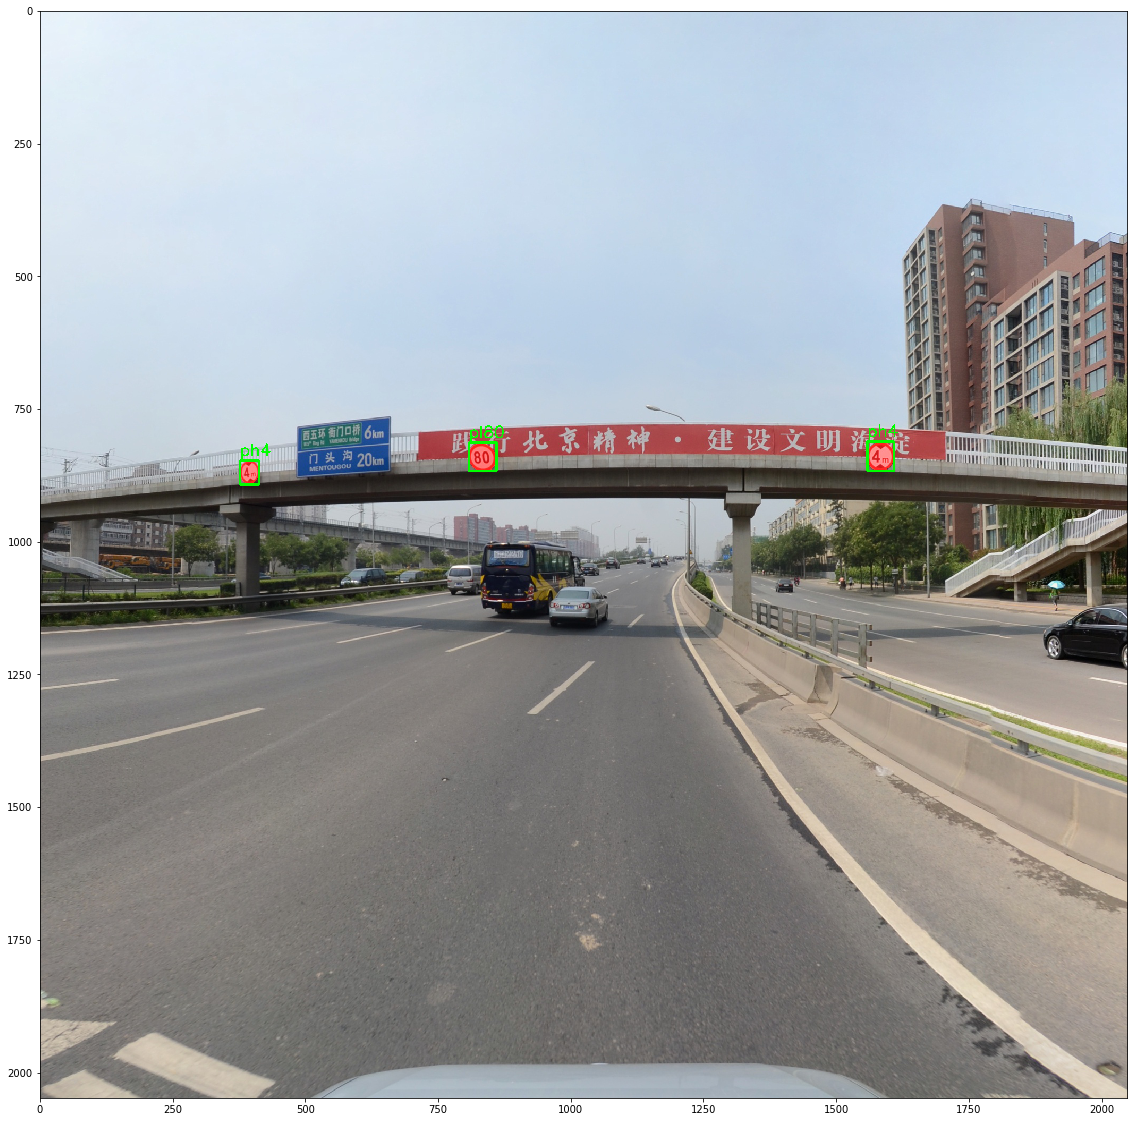

In [6]:
imgid = random.sample(ids, 1)[0]
print imgid

imgdata = anno_func.load_img(annos, datadir, imgid)
imgdata_draw = anno_func.draw_all(annos, datadir, imgid, imgdata)
pl.figure(figsize=(20,20))
pl.imshow(imgdata_draw)

## Prepare Dataset

In [ ]:
def create_annotation_info(annotation_id, image_id, category_id, bbox_xywh)